In [211]:
pip install plotly kaleido
pip install optuna
pip install kaleido


In [202]:
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import xgboost as xgb
import plotly.io as pio
import kaleido

In [148]:
new_df = pd.read_csv('insurance_claims.csv')
new_df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


# Checking for missing values, and addressing this

In [149]:
# Check if missing values exist in columns
missing_values_count = new_df.isnull().sum()

print(missing_values_count)

months_as_customer                0
age                               0
policy_number                     0
policy_bind_date                  0
policy_state                      0
policy_csl                        0
policy_deductable                 0
policy_annual_premium             0
umbrella_limit                    0
insured_zip                       0
insured_sex                       0
insured_education_level           0
insured_occupation                0
insured_hobbies                   0
insured_relationship              0
capital-gains                     0
capital-loss                      0
incident_date                     0
incident_type                     0
collision_type                    0
incident_severity                 0
authorities_contacted            91
incident_state                    0
incident_city                     0
incident_location                 0
incident_hour_of_the_day          0
number_of_vehicles_involved       0
property_damage             

Check the unique values

In [150]:
authorities_contacted = new_df['authorities_contacted'].value_counts()

print(authorities_contacted)


authorities_contacted
Police       292
Fire         223
Other        198
Ambulance    196
Name: count, dtype: int64


I don't know if the missing data implies that no authorities were contacted, or if somethings missing, so I'd like to do some investigation

In [151]:
# Filter rows with missing data in 'authorities_contacted'
missing_data_rows = new_df[new_df['authorities_contacted'].isnull()]

# Display the rows
print(missing_data_rows)

     months_as_customer  age  policy_number policy_bind_date policy_state  \
4                   228   44         367455       2014-06-06           IL   
13                  121   34         626808       2012-10-26           OH   
27                  202   34         608513       2002-07-18           IN   
37                  289   49         933293       1993-02-03           IL   
51                   91   27         537546       1994-08-20           IL   
..                  ...  ...            ...              ...          ...   
940                 308   47         720356       2013-09-16           OH   
942                 108   31         148498       2002-01-04           IN   
950                 101   27         557218       1997-11-23           IL   
953                 229   43         791425       1997-06-18           IN   
994                 141   30         681486       2007-03-24           IN   

    policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  \

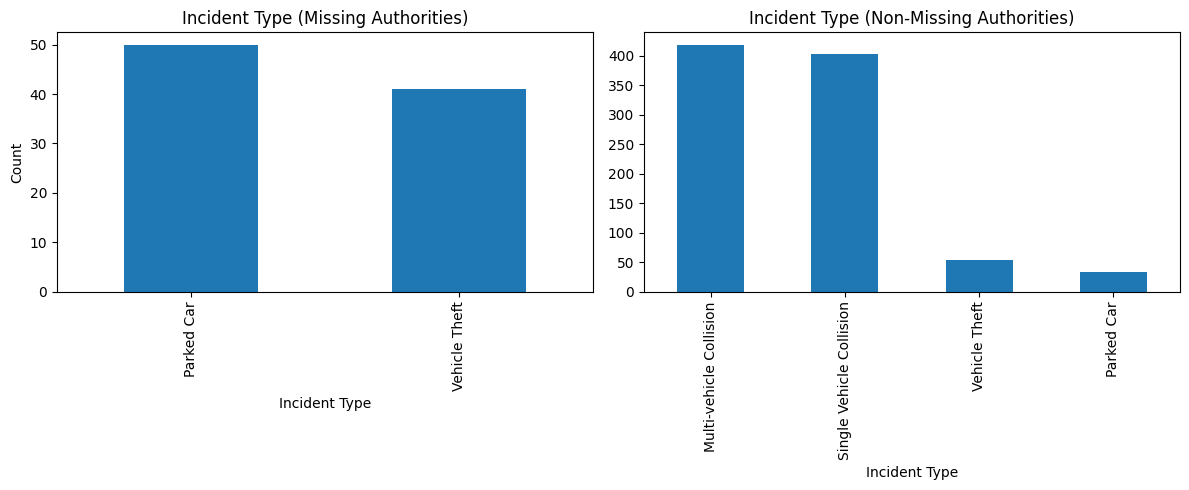

In [152]:
non_missing_data_rows = new_df[new_df['authorities_contacted'].notnull()]


# Count of incident types in missing and non-missing rows
missing_incident_counts = missing_data_rows['incident_type'].value_counts()
non_missing_incident_counts = non_missing_data_rows['incident_type'].value_counts()

# Create bar plots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

missing_incident_counts.plot(kind='bar', ax=ax[0], title='Incident Type (Missing Authorities)')
non_missing_incident_counts.plot(kind='bar', ax=ax[1], title='Incident Type (Non-Missing Authorities)')

ax[0].set_ylabel('Count')
ax[0].set_xlabel('Incident Type')
ax[1].set_xlabel('Incident Type')

plt.tight_layout()
plt.show()


This might be something, so I'll look into this further

Distribution of Authorities Contacted by Incident Type:
authorities_contacted     Ambulance      Fire     Other    Police
incident_type                                                    
Multi-vehicle Collision    0.238663  0.264916  0.238663  0.257757
Parked Car                 0.000000  0.000000  0.000000  1.000000
Single Vehicle Collision   0.238213  0.277916  0.243176  0.240695
Vehicle Theft              0.000000  0.000000  0.000000  1.000000


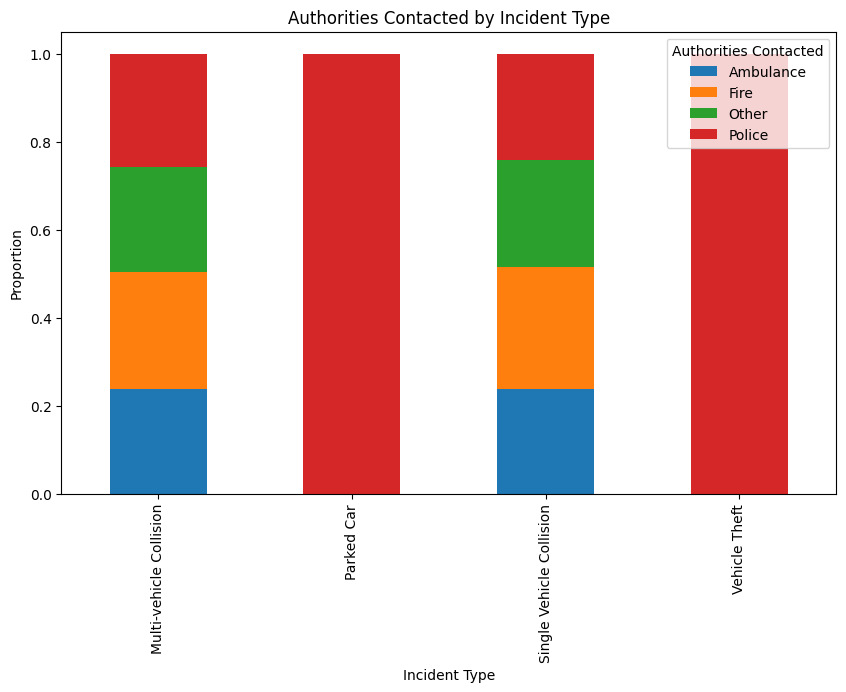

In [153]:
# Filter rows with non-missing values in "authorities_contacted"
non_missing = new_df[new_df['authorities_contacted'].notna()]

# Group by incident type and authorities contacted, and calculate proportions
authority_distribution = non_missing.groupby(['incident_type', 'authorities_contacted']).size().unstack().fillna(0)
authority_distribution = authority_distribution.div(authority_distribution.sum(axis=1), axis=0)

# Display the distribution
print("Distribution of Authorities Contacted by Incident Type:")
print(authority_distribution)

# Visualize the distribution
authority_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Authorities Contacted by Incident Type')
plt.xlabel('Incident Type')
plt.ylabel('Proportion')
plt.legend(title='Authorities Contacted')
plt.show()


At this point it would be safe to assume that the missing data should contain "Police"

In [154]:
# Replace missing values in "authorities_contacted" with "Police"
new_df['authorities_contacted'] = new_df['authorities_contacted'].fillna('Police')

# Check for remaining missing values in the column
print(new_df['authorities_contacted'].isna().sum())  # Should output 0



0


# Removing features which were not deemed important by other model testing

_c39 seems like an error, so we'll remove that completely

In [155]:
new_df = new_df.drop(columns=['_c39'])

auto model didn't seem to be significant, but increases the dimensionality by a lot, so I remove this variable

In [156]:
new_df = new_df.drop(columns=['auto_model'])
new_df = new_df.drop(columns=['auto_make'])

# Checking what are the numerical features and categorical features

In [157]:
numerical_features = new_df.select_dtypes(include=['number']).columns.tolist()
categorical_features = new_df.select_dtypes(include=['object', 'category']).columns.tolist()


print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['months_as_customer', 'age', 'policy_number', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'capital-gains', 'capital-loss', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'bodily_injuries', 'witnesses', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_year']
Categorical Features: ['policy_bind_date', 'policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'property_damage', 'police_report_available', 'fraud_reported']


# Checking the numerical features (distribution and summary statistics and boxplots)

In [158]:
print(new_df['insured_zip'].value_counts())


insured_zip
477695    2
469429    2
446895    2
431202    2
456602    2
         ..
476303    1
450339    1
476502    1
600561    1
612260    1
Name: count, Length: 995, dtype: int64


In [159]:
# Summary statistics
new_df[['policy_annual_premium', 'capital-gains', 'capital-loss', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim','age', 'months_as_customer']].describe()


,policy_annual_premium,capital-gains,capital-loss,total_claim_amount,injury_claim,property_claim,vehicle_claim,age,months_as_customer
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1256.406150,25126.100000,-26793.700000,52761.94000,7433.420000,7399.570000,37928.950000,38.948000,203.954000
std,244.167395,27872.187708,28104.096686,26401.53319,4880.951853,4824.726179,18886.252893,9.140287,115.113174
min,433.330000,0.000000,-111100.000000,100.00000,0.000000,0.000000,70.000000,19.000000,0.000000
25%,1089.607500,0.000000,-51500.000000,41812.50000,4295.000000,4445.000000,30292.500000,32.000000,115.750000
50%,1257.200000,0.000000,-23250.000000,58055.00000,6775.000000,6750.000000,42100.000000,38.000000,199.500000
75%,1415.695000,51025.000000,0.000000,70592.50000,11305.000000,10885.000000,50822.500000,44.000000,276.250000
max,2047.590000,100500.000000,0.000000,114920.00000,21450.000000,23670.000000,79560.000000,64.000000,479.000000


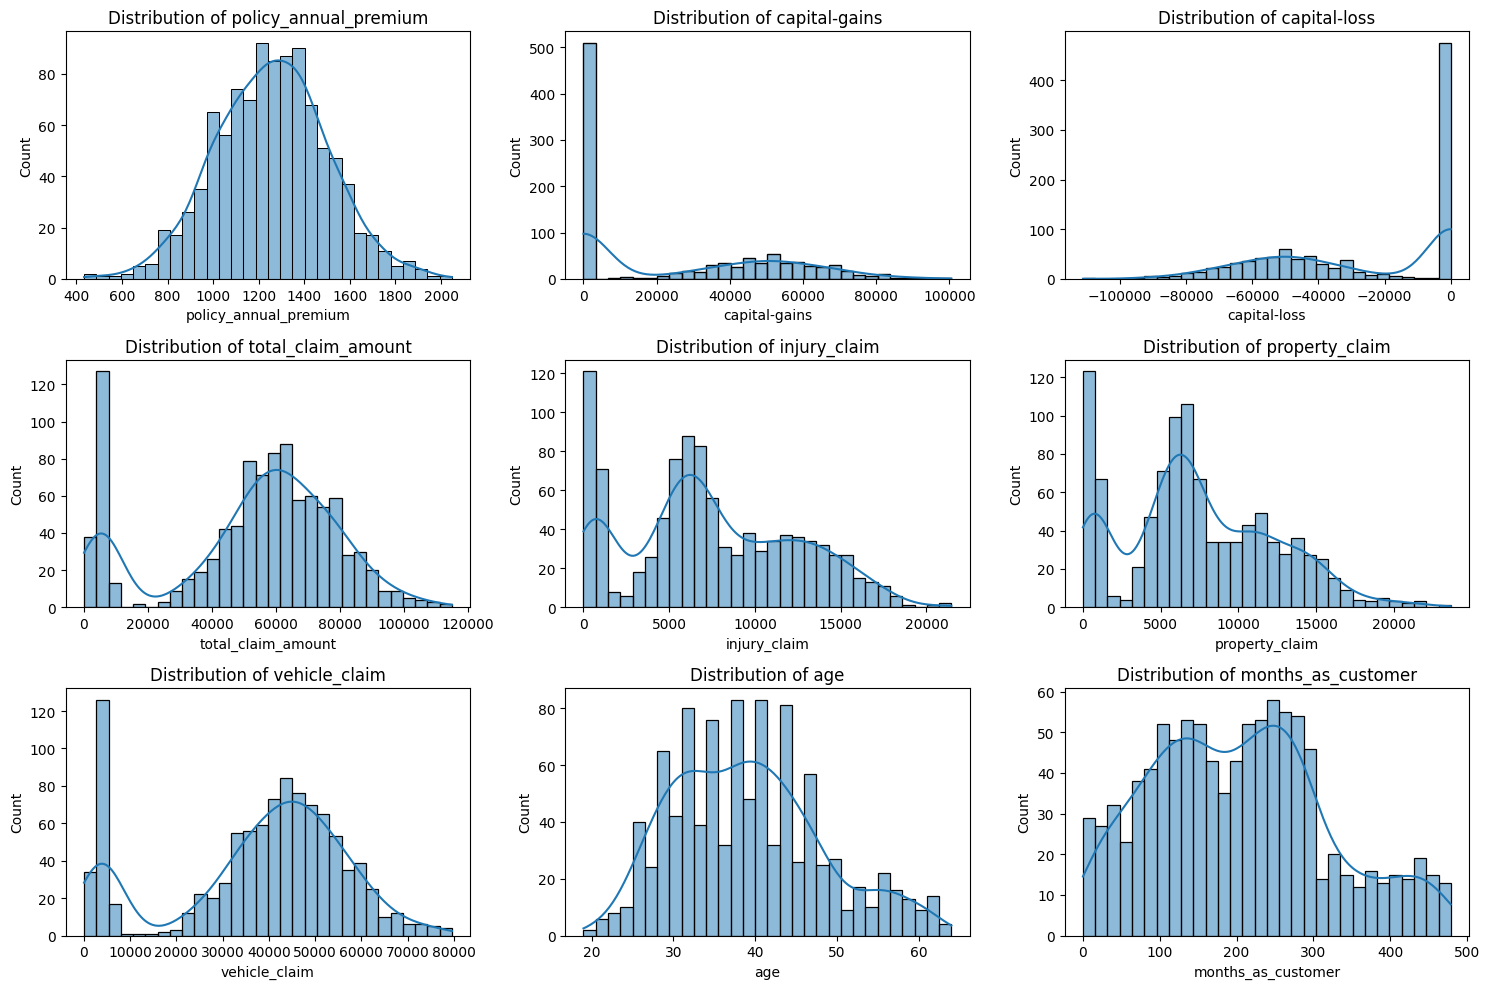

In [160]:
numerical_features = ['policy_annual_premium', 'capital-gains', 'capital-loss', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim','age', 'months_as_customer']


plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)  # Create a grid of subplots (3 rows, 4 columns)
    sns.histplot(new_df[feature], kde=True, bins=30)  # KDE for smoother distribution curve
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()

plt.show()

# Check ordinal features

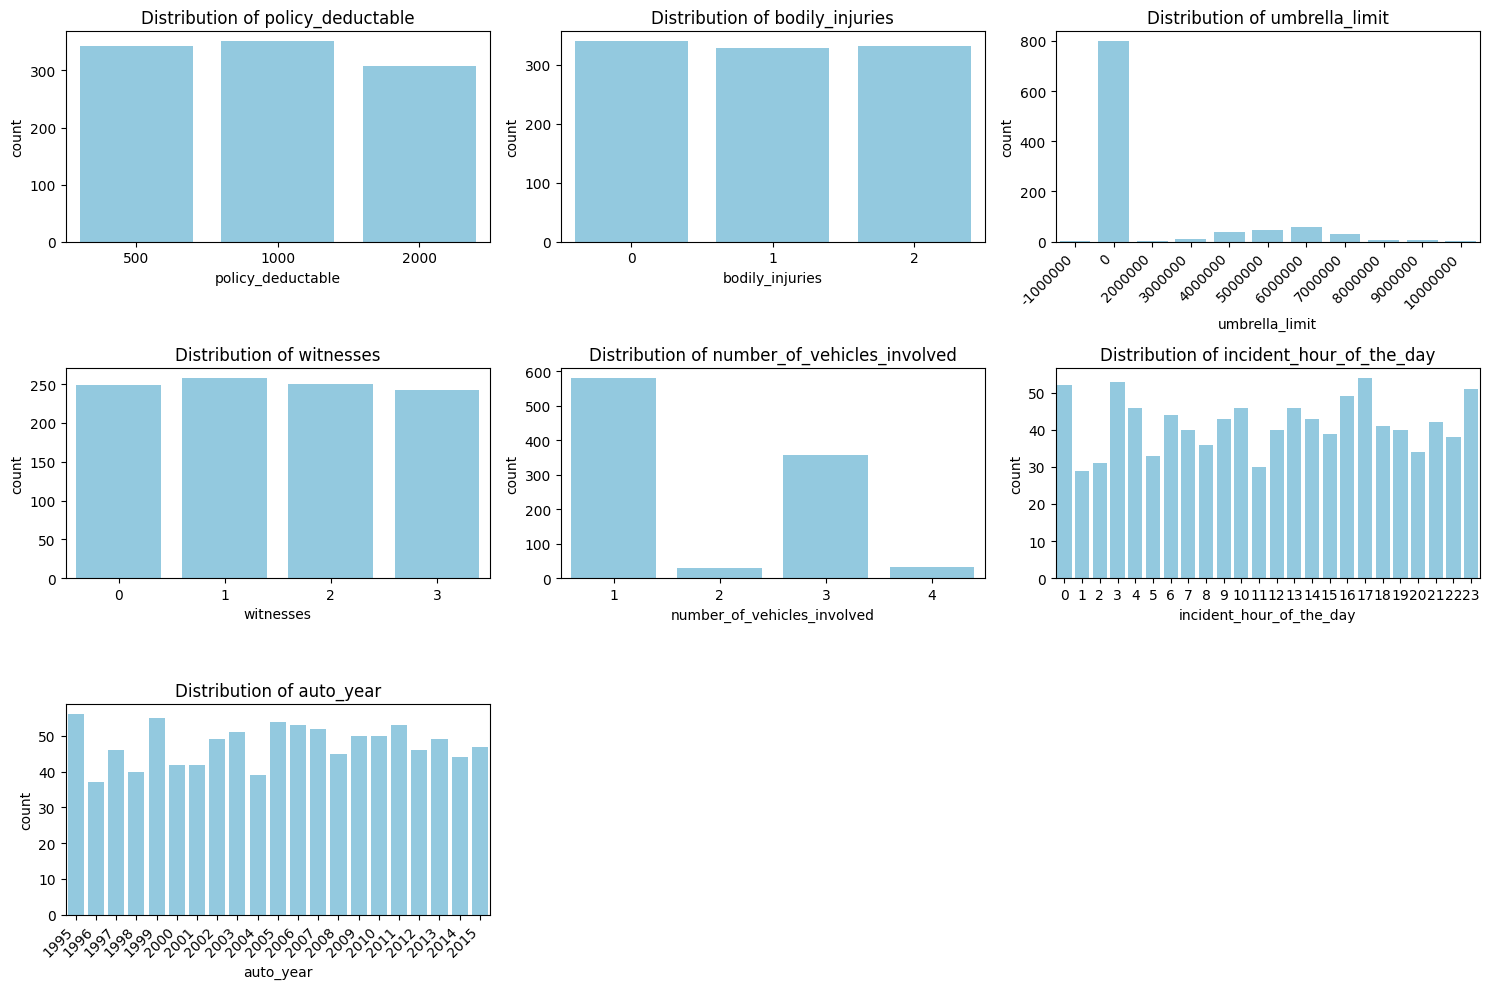

In [161]:
# List of ordinal features
ordinal_features = ['policy_deductable', 'bodily_injuries', 'umbrella_limit',
                    'witnesses', 'number_of_vehicles_involved', 'incident_hour_of_the_day',
                    'auto_year']

# Set the figure size
plt.figure(figsize=(15, 10))

# Create a grid of subplots (3 rows, 3 columns)
for i, feature in enumerate(ordinal_features):
    plt.subplot(3, 3, i+1)  # Create a 3x3 grid of subplots
    ax = sns.countplot(x=new_df[feature], color='skyblue')  # Set all counts to the same color
    plt.title(f'Distribution of {feature}')

    # Rotate x-axis labels for better visibility if the feature is 'auto_year'
    if feature == 'auto_year':
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels by 45 degrees for clarity
    if feature == 'umbrella_limit':
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels by 45 degrees for clarity

    # Adjust layout to prevent overlap
    plt.tight_layout()

# Display the plot
plt.show()



# identifying outliers (might come back to this, for now, I'm leaving them)

In [162]:
from scipy.stats import zscore

# Calculate Z-scores for the numerical features
z_scores = new_df[['policy_annual_premium', 'umbrella_limit', 'insured_zip', 'capital-gains', 'capital-loss', 'total_claim_amount',
                   'injury_claim', 'property_claim', 'vehicle_claim']].apply(zscore)

# Identify outliers (Z-score > 3 or Z-score < -3)
outliers = (z_scores.abs() > 3)
print(outliers)
outliers.value_counts()

     policy_annual_premium  umbrella_limit  insured_zip  capital-gains  \
0                    False           False        False          False   
1                    False           False        False          False   
2                    False           False        False          False   
3                    False           False        False          False   
4                    False           False        False          False   
..                     ...             ...          ...            ...   
995                  False           False        False          False   
996                  False           False        False          False   
997                  False           False        False          False   
998                  False           False        False          False   
999                  False           False        False          False   

     capital-loss  total_claim_amount  injury_claim  property_claim  \
0           False               False   

policy_annual_premium  umbrella_limit  insured_zip  capital-gains  capital-loss  total_claim_amount  injury_claim  property_claim  vehicle_claim
False                  False           False        False          False         False               False         False           False            980
                       True            False        False          False         False               False         False           False             15
True                   False           False        False          False         False               False         False           False              3
False                  False           False        False          False         False               False         True            False              1
                                                                   True          False               False         False           False              1
Name: count, dtype: int64

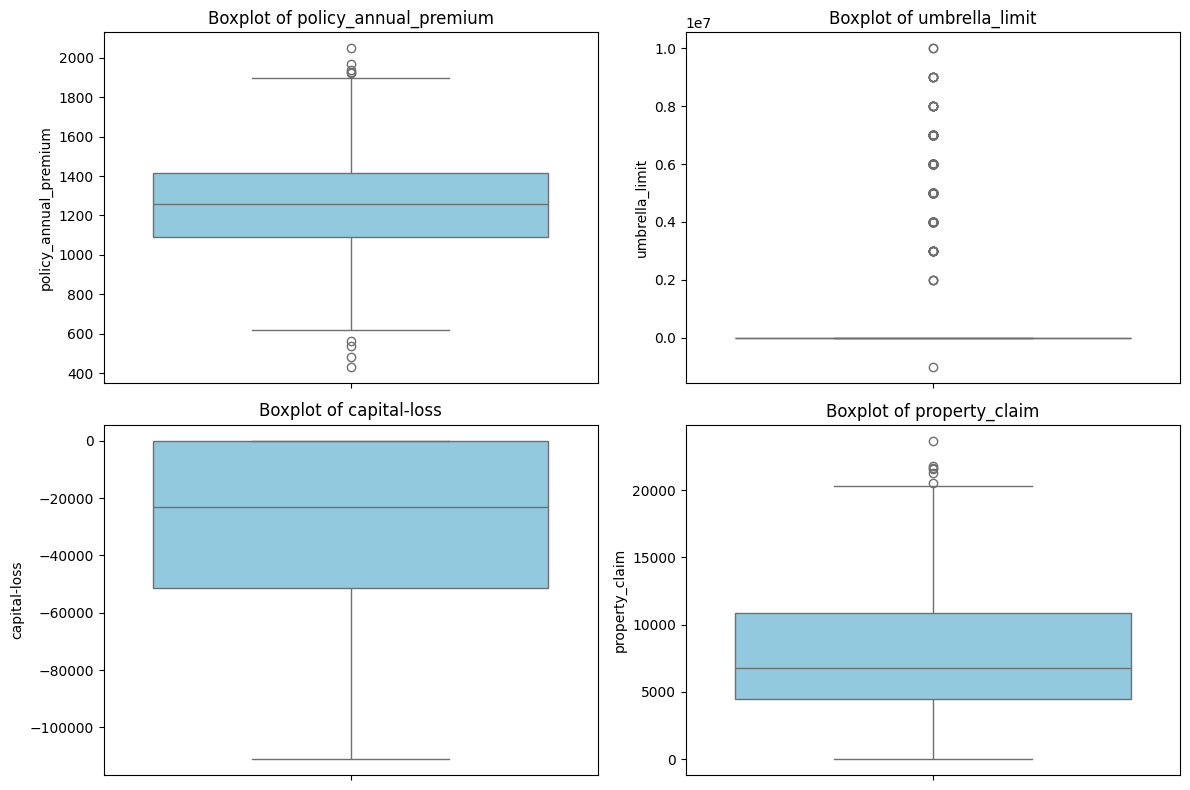

In [163]:
# Features for boxplot
boxplot_features = ['policy_annual_premium', 'umbrella_limit', 'capital-loss', 'property_claim']

# Set the figure size
plt.figure(figsize=(12, 8))

# Create a grid of subplots (2 rows, 2 columns)
for i, feature in enumerate(boxplot_features):
    plt.subplot(2, 2, i+1)  # Create a 2x2 grid of subplots
    sns.boxplot(y=new_df[feature], color='skyblue')  # Boxplot with consistent color
    plt.title(f'Boxplot of {feature}')  # Add title for each plot

    # Adjust layout to prevent overlap
    plt.tight_layout()

# Display the plot
plt.show()

# Checking Categorical features

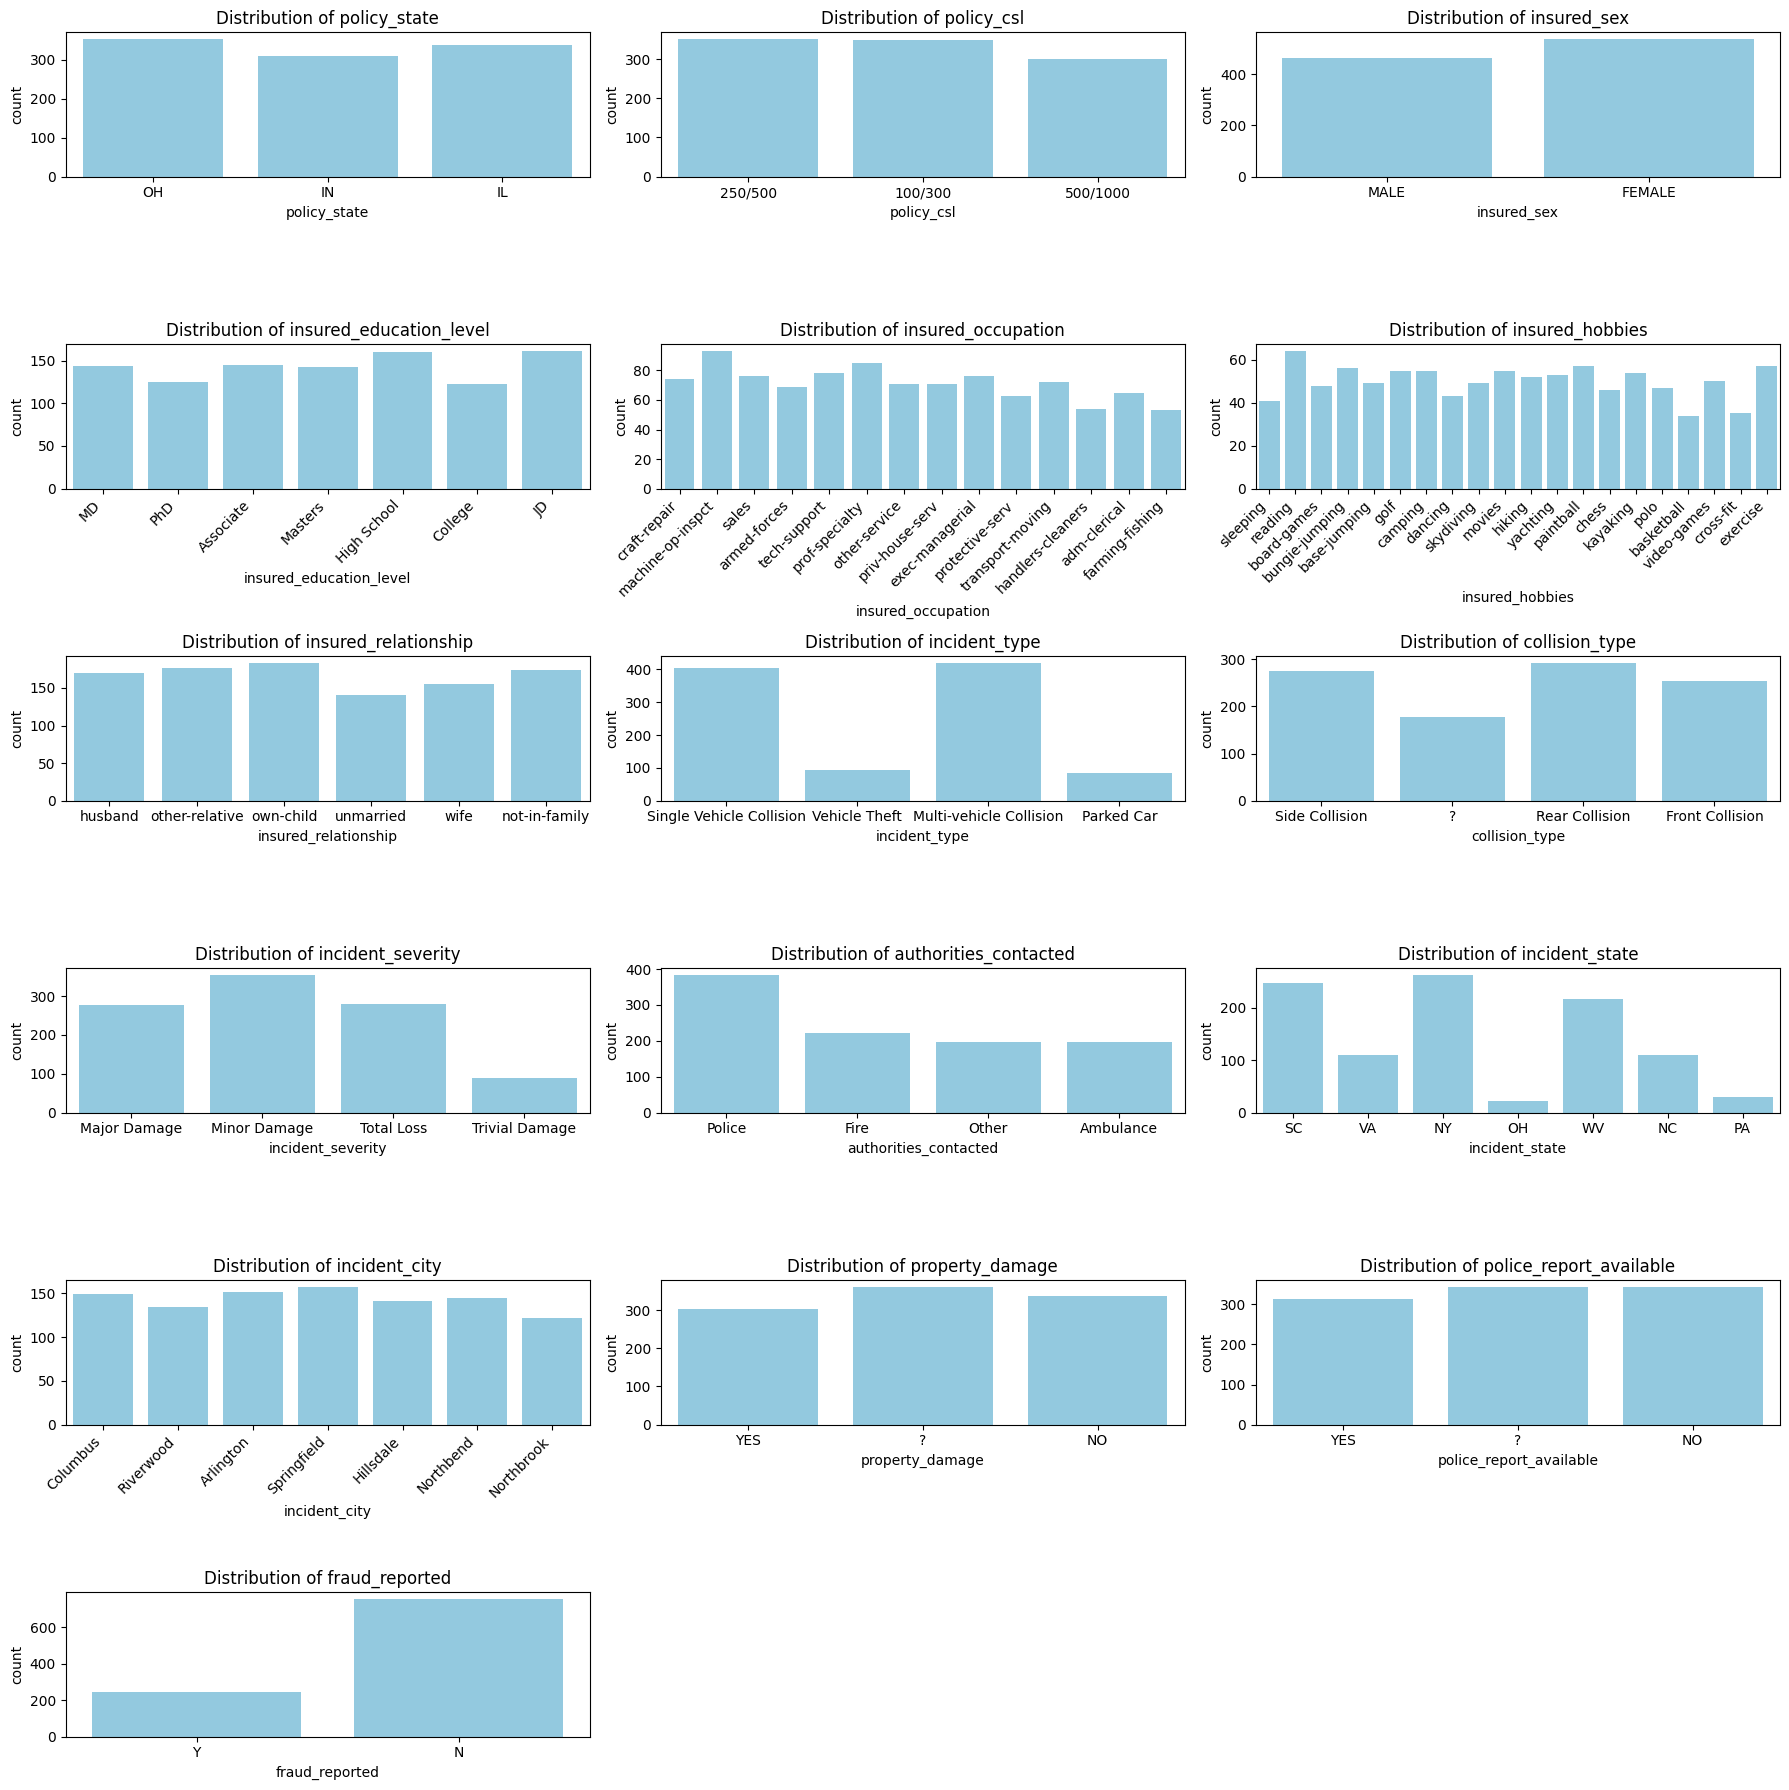

In [164]:
# List of categorical features
categorical_features = [
    'policy_state', 'policy_csl', 'insured_sex',
    'insured_education_level', 'insured_occupation', 'insured_hobbies',
    'insured_relationship', 'incident_type',
    'collision_type', 'incident_severity', 'authorities_contacted',
    'incident_state', 'incident_city', 'property_damage',
    'police_report_available', 'fraud_reported'
]

# Set the figure size
plt.figure(figsize=(18, 18))  # Adjusted size for more plots

# Create a grid of subplots (6 rows, 3 columns)
for i, feature in enumerate(categorical_features):
    plt.subplot(6, 3, i+1)  # Create a 6x3 grid of subplots
    ax = sns.countplot(x=new_df[feature], color='skyblue')  # Set all counts to the same color
    plt.title(f'Distribution of {feature}')

    # Rotate x-axis labels for better visibility for features with longer labels
    if feature in ['insured_education_level', 'insured_hobbies', 'incident_date', 'incident_city', 'insured_occupation']:
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels by 45 degrees for clarity

    # Adjust layout to prevent overlap
    plt.tight_layout()

# Display the plot
plt.show()

In [165]:
# List of categorical features
categorical_features = [
    'policy_bind_date', 'policy_state', 'policy_csl', 'insured_sex',
    'insured_education_level', 'insured_occupation', 'insured_hobbies',
    'insured_relationship', 'incident_date', 'incident_type',
    'collision_type', 'incident_severity', 'authorities_contacted',
    'incident_state', 'incident_city', 'incident_location', 'property_damage',
    'police_report_available', 'fraud_reported'
]

# Check the number of unique categories in each feature
category_counts = new_df[categorical_features].nunique()

print(category_counts)

policy_bind_date            951
policy_state                  3
policy_csl                    3
insured_sex                   2
insured_education_level       7
insured_occupation           14
insured_hobbies              20
insured_relationship          6
incident_date                60
incident_type                 4
collision_type                4
incident_severity             4
authorities_contacted         4
incident_state                7
incident_city                 7
incident_location          1000
property_damage               3
police_report_available       3
fraud_reported                2
dtype: int64


Based on this information. I've decided to get rid of the following variables:
- policy_bind_date,  
- incident locations, since there's too much categories.

The following because the feature importance was low:
- policy_state
- incident_city
- incident_state
- incident_occupation
- insured_hobbies
- insured_relationship


For the numerical:
- umbrella_limit


Convert the following using label encoding:
- policy_csl
- insured_education_level
- incident_severity

Convert the following using one-hot encoding
- insured_sex
- incident_type
- authorities_contacted
- property_damage
- police_report_available

extract new features from following:
- incident_date (create weekends and weekdays variable)


In [166]:
new_df = new_df.drop(columns=['policy_bind_date'])
new_df = new_df.drop(columns=['incident_location'])
new_df = new_df.drop(columns=['umbrella_limit'])
new_df = new_df.drop(columns=['policy_state'])
new_df = new_df.drop(columns=['incident_city'])
new_df = new_df.drop(columns=['incident_state'])
new_df = new_df.drop(columns=['insured_occupation'])
new_df = new_df.drop(columns=['insured_hobbies'])
new_df = new_df.drop(columns=['insured_relationship'])



In [167]:
policy_csl_distribution = new_df['policy_csl'].value_counts()
insured_education_level_distribution = new_df['insured_education_level'].value_counts()
incident_severity_distribution = new_df['incident_severity'].value_counts()
collision_type_distribution = new_df['collision_type'].value_counts()


print(policy_csl_distribution)
print(insured_education_level_distribution)
print(incident_severity_distribution)
print(collision_type_distribution)

policy_csl
250/500     351
100/300     349
500/1000    300
Name: count, dtype: int64
insured_education_level
JD             161
High School    160
Associate      145
MD             144
Masters        143
PhD            125
College        122
Name: count, dtype: int64
incident_severity
Minor Damage      354
Total Loss        280
Major Damage      276
Trivial Damage     90
Name: count, dtype: int64
collision_type
Rear Collision     292
Side Collision     276
Front Collision    254
?                  178
Name: count, dtype: int64


In [168]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Define the custom ranking
education_rank = {
    'High School': 0,
    'College': 1,
    'Associate': 2,
    'Masters': 3,
    'JD': 4,
    'MD': 5,
    'PhD': 6
}

csl_rank = {
    '100/300': 0,
    '250/500': 1,
    '500/1000': 2
}

severity_rank = {
    'Trivial Damage': 0,
    'Minor Damage': 1,
    'Major Damage': 2,
    'Total Loss': 3
}

# Apply the custom encoding based on the defined ranking
new_df['policy_csl_encoded'] = new_df['policy_csl'].map(csl_rank)
new_df['insured_education_level_encoded'] = new_df['insured_education_level'].map(education_rank)
new_df['incident_severity_encoded'] = new_df['incident_severity'].map(severity_rank)

# View the transformed values
print(new_df['policy_csl_encoded'].head())
print(new_df['insured_education_level_encoded'].head())
print(new_df['incident_severity_encoded'].head())

# Remove old features:
new_df = new_df.drop(columns=['policy_csl'])
new_df = new_df.drop(columns=['insured_education_level'])
new_df = new_df.drop(columns=['incident_severity'])




0    1
1    1
2    0
3    1
4    2
Name: policy_csl_encoded, dtype: int64
0    5
1    5
2    6
3    6
4    2
Name: insured_education_level_encoded, dtype: int64
0    2
1    1
2    1
3    2
4    1
Name: incident_severity_encoded, dtype: int64


In [169]:
# List of categorical features to one-hot encode
categorical_features = [
    'authorities_contacted', 'insured_sex', 'incident_type',
    'property_damage', 'police_report_available',
    'collision_type'
]

# One-hot encode the categorical features
new_df = pd.get_dummies(new_df, columns=categorical_features, drop_first=True)

# Ensure all dummy variables are integers (0 and 1)

dummy_columns = [col for col in new_df.columns if 'insured_sex' in col]
new_df[dummy_columns] = new_df[dummy_columns].astype(int)

dummy_columns = [col for col in new_df.columns if 'incident_type' in col]
new_df[dummy_columns] = new_df[dummy_columns].astype(int)

dummy_columns = [col for col in new_df.columns if 'authorities_contacted' in col]
new_df[dummy_columns] = new_df[dummy_columns].astype(int)

dummy_columns = [col for col in new_df.columns if 'property_damage' in col]
new_df[dummy_columns] = new_df[dummy_columns].astype(int)

dummy_columns = [col for col in new_df.columns if 'police_report_available' in col]
new_df[dummy_columns] = new_df[dummy_columns].astype(int)

dummy_columns = [col for col in new_df.columns if 'collision_type' in col]
new_df[dummy_columns] = new_df[dummy_columns].astype(int)

# Change the output variable to 0's and 1's
new_df['fraud_reported'] = new_df['fraud_reported'].replace({'Y': 1, 'N': 0})

# Verify the changes
print(new_df.head())

   months_as_customer  age  policy_number  policy_deductable  \
0                 328   48         521585               1000   
1                 228   42         342868               2000   
2                 134   29         687698               2000   
3                 256   41         227811               2000   
4                 228   44         367455               1000   

   policy_annual_premium  insured_zip  capital-gains  capital-loss  \
0                1406.91       466132          53300             0   
1                1197.22       468176              0             0   
2                1413.14       430632          35100             0   
3                1415.74       608117          48900        -62400   
4                1583.91       610706          66000        -46000   

  incident_date  incident_hour_of_the_day  ...  incident_type_Parked Car  \
0    2015-01-25                         5  ...                         0   
1    2015-01-21                         8 

<ipython-input-169-d9584e17e204>:32: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [170]:
# Convert 'incident_date' to datetime type
new_df['incident_date'] = pd.to_datetime(new_df['incident_date'], errors='coerce')

# Extract year, month, and day of the week
new_df['incident_year'] = new_df['incident_date'].dt.year
new_df['incident_month'] = new_df['incident_date'].dt.month
new_df['incident_day_of_week'] = new_df['incident_date'].dt.dayofweek

# Create a new feature 'is_weekend' where 1 = weekend (Saturday or Sunday), 0 = weekday (Monday to Friday)
new_df['is_weekend'] = new_df['incident_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Drop the original 'incident_date' column if no longer needed
new_df = new_df.drop(columns=['incident_date'])
new_df = new_df.drop(columns=['incident_day_of_week'])


# Check the new features
print(new_df[['incident_year', 'incident_month', 'is_weekend']].head())


   incident_year  incident_month  is_weekend
0           2015               1           1
1           2015               1           0
2           2015               2           1
3           2015               1           1
4           2015               2           0


# Building the Random Forest (Without SMOTE)

In [171]:
print(new_df.dtypes)


months_as_customer                          int64
age                                         int64
policy_number                               int64
policy_deductable                           int64
policy_annual_premium                     float64
insured_zip                                 int64
capital-gains                               int64
capital-loss                                int64
incident_hour_of_the_day                    int64
number_of_vehicles_involved                 int64
bodily_injuries                             int64
witnesses                                   int64
total_claim_amount                          int64
injury_claim                                int64
property_claim                              int64
vehicle_claim                               int64
auto_year                                   int64
fraud_reported                              int64
policy_csl_encoded                          int64
insured_education_level_encoded             int64


In [172]:
categorical_columns = new_df.select_dtypes(include=['object', 'category', 'bool']).columns
print("\nCategorical Columns:")
print(categorical_columns)


Categorical Columns:
Index([], dtype='object')


In [173]:
# Splitting the dataset

# Define features and target variable
X = new_df.drop('fraud_reported', axis=1)  # All columns except 'fraud_reported'
y = new_df['fraud_reported']  # Target variable

# Split the data into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Define hyperparameters



In [229]:
def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 30, 150)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5])
    class_weight = trial.suggest_categorical('class_weight', ['balanced'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 100)

    # Initialize the Random Forest model
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight=class_weight,
        max_leaf_nodes=max_leaf_nodes,
        random_state=42
    )

    # Perform 3-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Custom scorer to count true positives
    def true_positive_scorer(model, X, y):
        # Get predicted probabilities
        probs = model.predict_proba(X)[:, 1]  # Probabilities for the positive class (fraudulent)
        predictions = (probs >= 0.5).astype(int)  # Apply threshold
        true_positives = ((predictions == 1) & (y == 1)).sum()  # Count of true positives
        return true_positives

    # Use cross-validation and custom scoring
    total_true_positives = 0
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        rf.fit(X_train_fold, y_train_fold)
        fold_true_positives = true_positive_scorer(rf, X_test_fold, y_test_fold)
        total_true_positives += fold_true_positives

    # Log the total number of true positives
    print(f"Total True Positives (Fraudulent Cases Correctly Predicted): {total_true_positives}")

    return total_true_positives  # Optimize for the count of true positives



In [230]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-11-30 16:33:49,904] A new study created in memory with name: no-name-250a844f-3380-4fb4-8b0c-b10f083530a1
[I 2024-11-30 16:33:50,317] Trial 0 finished with value: 92.0 and parameters: {'n_estimators': 56, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 13}. Best is trial 0 with value: 92.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 92


[I 2024-11-30 16:33:51,236] Trial 1 finished with value: 91.0 and parameters: {'n_estimators': 146, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 80}. Best is trial 0 with value: 92.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 91


[I 2024-11-30 16:33:51,691] Trial 2 finished with value: 69.0 and parameters: {'n_estimators': 68, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 65}. Best is trial 0 with value: 92.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 69


[I 2024-11-30 16:33:52,346] Trial 3 finished with value: 102.0 and parameters: {'n_estimators': 115, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 21}. Best is trial 3 with value: 102.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 102


[I 2024-11-30 16:33:53,370] Trial 4 finished with value: 115.0 and parameters: {'n_estimators': 142, 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 87}. Best is trial 4 with value: 115.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 115


[I 2024-11-30 16:33:53,895] Trial 5 finished with value: 101.0 and parameters: {'n_estimators': 83, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 95}. Best is trial 4 with value: 115.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 101


[I 2024-11-30 16:33:54,570] Trial 6 finished with value: 115.0 and parameters: {'n_estimators': 79, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 10}. Best is trial 4 with value: 115.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 115


[I 2024-11-30 16:33:55,001] Trial 7 finished with value: 95.0 and parameters: {'n_estimators': 68, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 87}. Best is trial 4 with value: 115.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 95


[I 2024-11-30 16:33:55,698] Trial 8 finished with value: 85.0 and parameters: {'n_estimators': 114, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 14}. Best is trial 4 with value: 115.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 85


[I 2024-11-30 16:33:56,511] Trial 9 finished with value: 110.0 and parameters: {'n_estimators': 99, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 17}. Best is trial 4 with value: 115.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 110


[I 2024-11-30 16:33:57,775] Trial 10 finished with value: 110.0 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 46}. Best is trial 4 with value: 115.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 110


[I 2024-11-30 16:33:58,216] Trial 11 finished with value: 108.0 and parameters: {'n_estimators': 32, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 47}. Best is trial 4 with value: 115.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 108


[I 2024-11-30 16:33:59,623] Trial 12 finished with value: 116.0 and parameters: {'n_estimators': 128, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 70}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 116


[I 2024-11-30 16:34:01,159] Trial 13 finished with value: 116.0 and parameters: {'n_estimators': 129, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 68}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 116


[I 2024-11-30 16:34:02,232] Trial 14 finished with value: 116.0 and parameters: {'n_estimators': 126, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 68}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 116


[I 2024-11-30 16:34:03,384] Trial 15 finished with value: 108.0 and parameters: {'n_estimators': 130, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 63}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 108


[I 2024-11-30 16:34:04,274] Trial 16 finished with value: 110.0 and parameters: {'n_estimators': 105, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 33}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 110


[I 2024-11-30 16:34:05,241] Trial 17 finished with value: 116.0 and parameters: {'n_estimators': 129, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 74}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 116


[I 2024-11-30 16:34:06,093] Trial 18 finished with value: 110.0 and parameters: {'n_estimators': 99, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 55}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 110


[I 2024-11-30 16:34:06,893] Trial 19 finished with value: 78.0 and parameters: {'n_estimators': 119, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 100}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 78


[I 2024-11-30 16:34:07,937] Trial 20 finished with value: 114.0 and parameters: {'n_estimators': 139, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 55}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 114


[I 2024-11-30 16:34:08,917] Trial 21 finished with value: 116.0 and parameters: {'n_estimators': 130, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 68}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 116


[I 2024-11-30 16:34:09,926] Trial 22 finished with value: 112.0 and parameters: {'n_estimators': 123, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 76}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 112


[I 2024-11-30 16:34:10,767] Trial 23 finished with value: 115.0 and parameters: {'n_estimators': 109, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 69}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 115


[I 2024-11-30 16:34:12,096] Trial 24 finished with value: 113.0 and parameters: {'n_estimators': 135, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 61}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 113


[I 2024-11-30 16:34:13,186] Trial 25 finished with value: 116.0 and parameters: {'n_estimators': 92, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 47}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 116


[I 2024-11-30 16:34:14,775] Trial 26 finished with value: 112.0 and parameters: {'n_estimators': 123, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 83}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 112


[I 2024-11-30 16:34:15,935] Trial 27 finished with value: 116.0 and parameters: {'n_estimators': 138, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 73}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 116


[I 2024-11-30 16:34:16,652] Trial 28 finished with value: 92.0 and parameters: {'n_estimators': 107, 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 36}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 92


[I 2024-11-30 16:34:16,898] Trial 29 finished with value: 89.0 and parameters: {'n_estimators': 33, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 60}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 89


[I 2024-11-30 16:34:17,249] Trial 30 finished with value: 100.0 and parameters: {'n_estimators': 49, 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 91}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 100


[I 2024-11-30 16:34:18,236] Trial 31 finished with value: 116.0 and parameters: {'n_estimators': 130, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 75}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 116


[I 2024-11-30 16:34:19,181] Trial 32 finished with value: 116.0 and parameters: {'n_estimators': 125, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 79}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 116


[I 2024-11-30 16:34:20,281] Trial 33 finished with value: 116.0 and parameters: {'n_estimators': 145, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 71}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 116


[I 2024-11-30 16:34:21,170] Trial 34 finished with value: 115.0 and parameters: {'n_estimators': 116, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 58}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 115


[I 2024-11-30 16:34:22,297] Trial 35 finished with value: 112.0 and parameters: {'n_estimators': 132, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 83}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 112


[I 2024-11-30 16:34:23,172] Trial 36 finished with value: 107.0 and parameters: {'n_estimators': 150, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 66}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 107


[I 2024-11-30 16:34:24,142] Trial 37 finished with value: 72.0 and parameters: {'n_estimators': 142, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 80}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 72


[I 2024-11-30 16:34:25,206] Trial 38 finished with value: 113.0 and parameters: {'n_estimators': 123, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 52}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 113


[I 2024-11-30 16:34:26,782] Trial 39 finished with value: 115.0 and parameters: {'n_estimators': 116, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 66}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 115


[I 2024-11-30 16:34:27,906] Trial 40 finished with value: 78.0 and parameters: {'n_estimators': 111, 'max_depth': 7, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 88}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 78


[I 2024-11-30 16:34:29,263] Trial 41 finished with value: 116.0 and parameters: {'n_estimators': 134, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 71}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 116


[I 2024-11-30 16:34:30,239] Trial 42 finished with value: 116.0 and parameters: {'n_estimators': 127, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 68}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 116


[I 2024-11-30 16:34:31,031] Trial 43 finished with value: 114.0 and parameters: {'n_estimators': 102, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 76}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 114


[I 2024-11-30 16:34:31,849] Trial 44 finished with value: 110.0 and parameters: {'n_estimators': 93, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 65}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 110


[I 2024-11-30 16:34:32,607] Trial 45 finished with value: 109.0 and parameters: {'n_estimators': 119, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 51}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 109


[I 2024-11-30 16:34:33,330] Trial 46 finished with value: 112.0 and parameters: {'n_estimators': 81, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 83}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 112


[I 2024-11-30 16:34:34,408] Trial 47 finished with value: 116.0 and parameters: {'n_estimators': 139, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 62}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 116


[I 2024-11-30 16:34:35,491] Trial 48 finished with value: 112.0 and parameters: {'n_estimators': 128, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 78}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 112


[I 2024-11-30 16:34:36,608] Trial 49 finished with value: 114.0 and parameters: {'n_estimators': 147, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 41}. Best is trial 12 with value: 116.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 114


In [231]:
# The best parameters:

print("Best parameters:", study.best_params)
print("Best recall:", study.best_value)

Best parameters: {'n_estimators': 128, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 70}
Best recall: 116.0


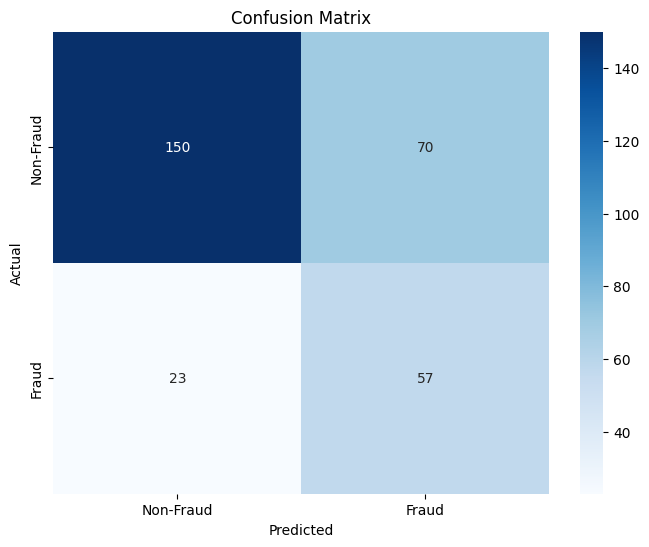

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.68      0.76       220
           1       0.45      0.71      0.55        80

    accuracy                           0.69       300
   macro avg       0.66      0.70      0.66       300
weighted avg       0.76      0.69      0.71       300



In [232]:
# Train the model with the best parameters
best_params = study.best_params
rf_best = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    class_weight=best_params['class_weight'],
    random_state=80
)

# Fit on training data
rf_best.fit(X_train, y_train)

# Evaluate on the test set
probs_test = rf_best.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
threshold = 0.5
y_pred = (probs_test >= threshold).astype(int)



# Generate the confusion matrix
cm1 = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Print the classification report (precision, recall, F1 score)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))


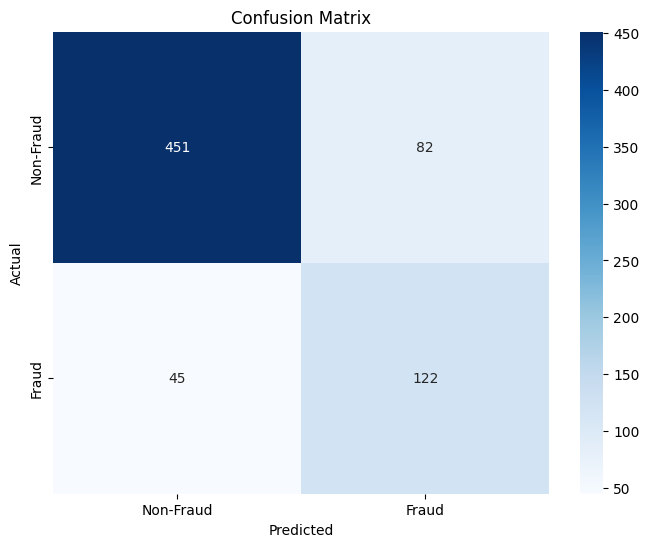

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       533
           1       0.60      0.73      0.66       167

    accuracy                           0.82       700
   macro avg       0.75      0.79      0.77       700
weighted avg       0.84      0.82      0.82       700



In [233]:
probs_train = rf_best.predict_proba(X_train)[:, 1]
y_train_pred = (probs_train >= 0.53).astype(int)


# Generate the confusion matrix
cm = confusion_matrix(y_train, y_train_pred)

# Plot confusion matrix using seaborn heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Print the classification report (precision, recall, F1 score)
print("Classification Report:\n")
print(classification_report(y_train, y_train_pred))

In [238]:
optuna.visualization.plot_optimization_history(study).show()

In [180]:
# plot of hyperparameter importance

optuna.visualization.plot_param_importances(study).show()

Get the feature importances

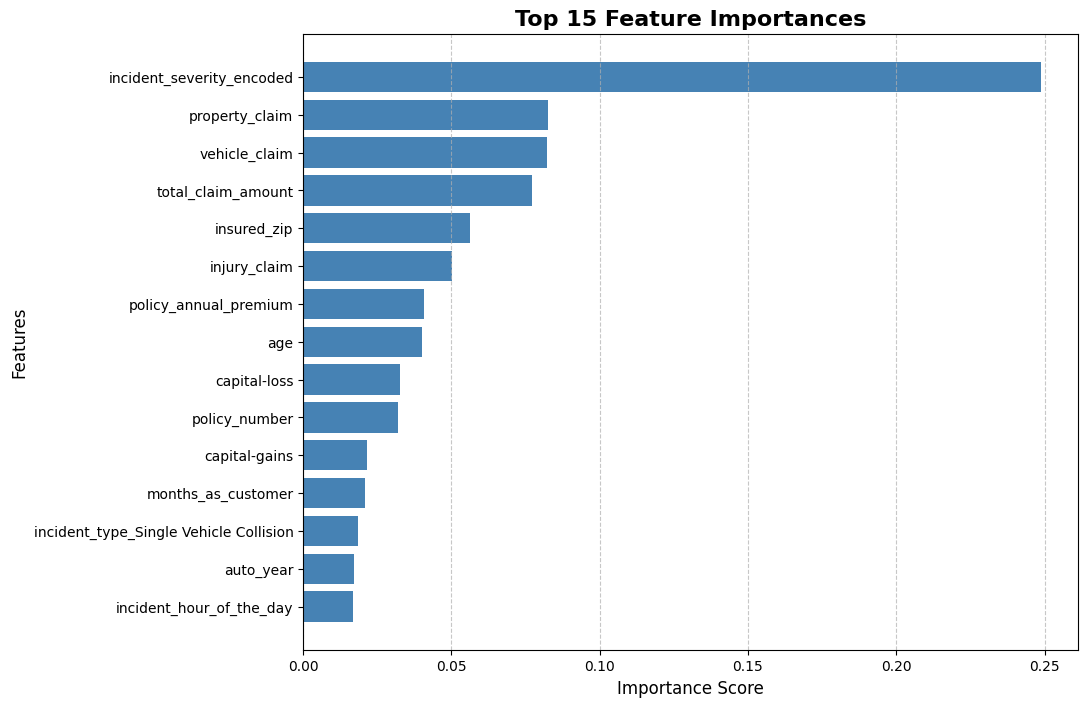

In [181]:
# Get feature importances from the final model
feature_importances = rf_best.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to sort and select the top 15 features
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).head(15)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.gca().invert_yaxis()  # To show the most important feature on top
plt.title('Top 15 Feature Importances', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add light gridlines for the x-axis
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Building the Random Forest (With SMOTE)

In [182]:
def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5])
    class_weight = trial.suggest_categorical('class_weight', ['balanced'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 100)
    smote_k_neighbors = trial.suggest_int('k_neighbors', 2, 10)

    # Initialize the Random Forest model
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight=class_weight,
        max_leaf_nodes=max_leaf_nodes,
        random_state=42
    )

    # Create a pipeline with SMOTE and the classifier
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42, k_neighbors=smote_k_neighbors)),
        ('classifier', rf)
    ])

    # Perform 3-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    def total_true_positives_scorer(model, X, y):
        # Get predicted probabilities
        probs = model.predict_proba(X)[:, 1]  # Probabilities for the positive class (fraudulent)
        predictions = (probs >= 0.5).astype(int)  # Apply threshold
        true_positives = ((predictions == 1) & (y == 1)).sum()  # Count of true positives
        return true_positives

    # Use cross-validation and custom scoring
    total_true_positives = 0
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Apply SMOTE only to the training fold
        smote = SMOTE(random_state=42, k_neighbors=smote_k_neighbors)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

        # Fit the pipeline
        pipeline.fit(X_train_resampled, y_train_resampled)
        fold_true_positives = total_true_positives_scorer(pipeline, X_test_fold, y_test_fold)
        total_true_positives += fold_true_positives

    # Log the total true positives
    print(f"Total True Positives (Fraudulent Cases Correctly Predicted): {total_true_positives}")

    return total_true_positives  # Optimize for the total number of true positives


In [183]:
import optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-11-30 16:00:26,279] A new study created in memory with name: no-name-aaa24341-1e12-4a30-9031-defe7e434024
[I 2024-11-30 16:00:27,224] Trial 0 finished with value: 72.0 and parameters: {'n_estimators': 112, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 89, 'k_neighbors': 2}. Best is trial 0 with value: 72.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 72


[I 2024-11-30 16:00:27,841] Trial 1 finished with value: 70.0 and parameters: {'n_estimators': 75, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 31, 'k_neighbors': 9}. Best is trial 0 with value: 72.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 70


[I 2024-11-30 16:00:29,031] Trial 2 finished with value: 94.0 and parameters: {'n_estimators': 81, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 34, 'k_neighbors': 7}. Best is trial 2 with value: 94.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 94


[I 2024-11-30 16:00:29,560] Trial 3 finished with value: 61.0 and parameters: {'n_estimators': 61, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 48, 'k_neighbors': 2}. Best is trial 2 with value: 94.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 61


[I 2024-11-30 16:00:30,185] Trial 4 finished with value: 61.0 and parameters: {'n_estimators': 72, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 67, 'k_neighbors': 2}. Best is trial 2 with value: 94.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 61


[I 2024-11-30 16:00:31,612] Trial 5 finished with value: 72.0 and parameters: {'n_estimators': 186, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 16, 'k_neighbors': 4}. Best is trial 2 with value: 94.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 72


[I 2024-11-30 16:00:32,951] Trial 6 finished with value: 61.0 and parameters: {'n_estimators': 165, 'max_depth': 15, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 40, 'k_neighbors': 8}. Best is trial 2 with value: 94.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 61


[I 2024-11-30 16:00:33,530] Trial 7 finished with value: 62.0 and parameters: {'n_estimators': 64, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 63, 'k_neighbors': 9}. Best is trial 2 with value: 94.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 62


[I 2024-11-30 16:00:34,633] Trial 8 finished with value: 90.0 and parameters: {'n_estimators': 72, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 29, 'k_neighbors': 2}. Best is trial 2 with value: 94.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 90


[I 2024-11-30 16:00:36,221] Trial 9 finished with value: 103.0 and parameters: {'n_estimators': 86, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 24, 'k_neighbors': 6}. Best is trial 9 with value: 103.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 103


[I 2024-11-30 16:00:38,016] Trial 10 finished with value: 117.0 and parameters: {'n_estimators': 121, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 16, 'k_neighbors': 5}. Best is trial 10 with value: 117.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 117


[I 2024-11-30 16:00:39,180] Trial 11 finished with value: 117.0 and parameters: {'n_estimators': 117, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 12, 'k_neighbors': 5}. Best is trial 10 with value: 117.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 117


[I 2024-11-30 16:00:40,522] Trial 12 finished with value: 117.0 and parameters: {'n_estimators': 138, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 10, 'k_neighbors': 5}. Best is trial 10 with value: 117.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 117


[I 2024-11-30 16:00:41,661] Trial 13 finished with value: 119.0 and parameters: {'n_estimators': 117, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 10, 'k_neighbors': 4}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 119


[I 2024-11-30 16:00:42,870] Trial 14 finished with value: 62.0 and parameters: {'n_estimators': 141, 'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 84, 'k_neighbors': 4}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 62


[I 2024-11-30 16:00:43,996] Trial 15 finished with value: 119.0 and parameters: {'n_estimators': 102, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 50, 'k_neighbors': 4}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 119


[I 2024-11-30 16:00:45,406] Trial 16 finished with value: 107.0 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 100, 'k_neighbors': 4}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 107


[I 2024-11-30 16:00:47,379] Trial 17 finished with value: 106.0 and parameters: {'n_estimators': 145, 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 52, 'k_neighbors': 3}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 106


[I 2024-11-30 16:00:48,280] Trial 18 finished with value: 74.0 and parameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 71, 'k_neighbors': 6}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 74


[I 2024-11-30 16:00:50,781] Trial 19 finished with value: 114.0 and parameters: {'n_estimators': 160, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 77, 'k_neighbors': 3}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 114


[I 2024-11-30 16:00:52,324] Trial 20 finished with value: 109.0 and parameters: {'n_estimators': 95, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 5, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 43, 'k_neighbors': 7}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 109


[I 2024-11-30 16:00:53,566] Trial 21 finished with value: 116.0 and parameters: {'n_estimators': 127, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 20, 'k_neighbors': 5}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 116


[I 2024-11-30 16:00:54,894] Trial 22 finished with value: 118.0 and parameters: {'n_estimators': 123, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 58, 'k_neighbors': 4}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 118


[I 2024-11-30 16:00:56,062] Trial 23 finished with value: 113.0 and parameters: {'n_estimators': 105, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 59, 'k_neighbors': 3}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 113


[I 2024-11-30 16:00:58,033] Trial 24 finished with value: 108.0 and parameters: {'n_estimators': 130, 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 6, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 55, 'k_neighbors': 4}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 108


[I 2024-11-30 16:00:59,455] Trial 25 finished with value: 86.0 and parameters: {'n_estimators': 154, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 43, 'k_neighbors': 3}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 86


[I 2024-11-30 16:01:01,289] Trial 26 finished with value: 119.0 and parameters: {'n_estimators': 175, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 77, 'k_neighbors': 4}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 119


[I 2024-11-30 16:01:04,585] Trial 27 finished with value: 106.0 and parameters: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 95, 'k_neighbors': 6}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 106


[I 2024-11-30 16:01:05,888] Trial 28 finished with value: 104.0 and parameters: {'n_estimators': 89, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 9, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 77, 'k_neighbors': 10}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 104


[I 2024-11-30 16:01:06,916] Trial 29 finished with value: 61.0 and parameters: {'n_estimators': 109, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 87, 'k_neighbors': 5}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 61


[I 2024-11-30 16:01:07,668] Trial 30 finished with value: 102.0 and parameters: {'n_estimators': 50, 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 78, 'k_neighbors': 3}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 102


[I 2024-11-30 16:01:09,494] Trial 31 finished with value: 118.0 and parameters: {'n_estimators': 175, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 62, 'k_neighbors': 4}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 118


[I 2024-11-30 16:01:10,902] Trial 32 finished with value: 114.0 and parameters: {'n_estimators': 113, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 71, 'k_neighbors': 4}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 114


[I 2024-11-30 16:01:12,302] Trial 33 finished with value: 115.0 and parameters: {'n_estimators': 130, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 51, 'k_neighbors': 5}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 115


[I 2024-11-30 16:01:14,186] Trial 34 finished with value: 102.0 and parameters: {'n_estimators': 151, 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 36, 'k_neighbors': 7}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 102


[I 2024-11-30 16:01:15,627] Trial 35 finished with value: 87.0 and parameters: {'n_estimators': 135, 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 46, 'k_neighbors': 2}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 87


[I 2024-11-30 16:01:19,173] Trial 36 finished with value: 107.0 and parameters: {'n_estimators': 120, 'max_depth': 6, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 31, 'k_neighbors': 3}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 107


[I 2024-11-30 16:01:20,571] Trial 37 finished with value: 88.0 and parameters: {'n_estimators': 181, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 68, 'k_neighbors': 4}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 88


[I 2024-11-30 16:01:22,640] Trial 38 finished with value: 108.0 and parameters: {'n_estimators': 199, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 58, 'k_neighbors': 2}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 108


[I 2024-11-30 16:01:24,235] Trial 39 finished with value: 118.0 and parameters: {'n_estimators': 168, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 91, 'k_neighbors': 6}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 118


[I 2024-11-30 16:01:25,130] Trial 40 finished with value: 70.0 and parameters: {'n_estimators': 108, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 82, 'k_neighbors': 7}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 70


[I 2024-11-30 16:01:27,032] Trial 41 finished with value: 118.0 and parameters: {'n_estimators': 182, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 61, 'k_neighbors': 4}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 118


[I 2024-11-30 16:01:28,847] Trial 42 finished with value: 118.0 and parameters: {'n_estimators': 172, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 66, 'k_neighbors': 4}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 118


[I 2024-11-30 16:01:31,217] Trial 43 finished with value: 117.0 and parameters: {'n_estimators': 189, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 73, 'k_neighbors': 5}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 117


[I 2024-11-30 16:01:32,769] Trial 44 finished with value: 109.0 and parameters: {'n_estimators': 83, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 64, 'k_neighbors': 3}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 109


[I 2024-11-30 16:01:34,699] Trial 45 finished with value: 119.0 and parameters: {'n_estimators': 172, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 8, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 38, 'k_neighbors': 4}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 119


[I 2024-11-30 16:01:35,759] Trial 46 finished with value: 66.0 and parameters: {'n_estimators': 117, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_leaf_nodes': 36, 'k_neighbors': 5}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 66


[I 2024-11-30 16:01:37,148] Trial 47 finished with value: 119.0 and parameters: {'n_estimators': 146, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 25, 'k_neighbors': 4}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 119


[I 2024-11-30 16:01:38,650] Trial 48 finished with value: 117.0 and parameters: {'n_estimators': 161, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 26, 'k_neighbors': 3}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 117


[I 2024-11-30 16:01:39,680] Trial 49 finished with value: 89.0 and parameters: {'n_estimators': 149, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 'log2', 'class_weight': 'balanced', 'max_leaf_nodes': 20, 'k_neighbors': 2}. Best is trial 13 with value: 119.0.


Total True Positives (Fraudulent Cases Correctly Predicted): 89


In [184]:
# Get the best hyperparameters from the Optuna study
best_params = study.best_params
print("Best Parameters:", best_params)

Best Parameters: {'n_estimators': 117, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': 0.5, 'class_weight': 'balanced', 'max_leaf_nodes': 10, 'k_neighbors': 4}


Confusion Matrix:
 [[120 100]
 [ 16  64]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.55      0.67       220
           1       0.39      0.80      0.52        80

    accuracy                           0.61       300
   macro avg       0.64      0.67      0.60       300
weighted avg       0.75      0.61      0.63       300



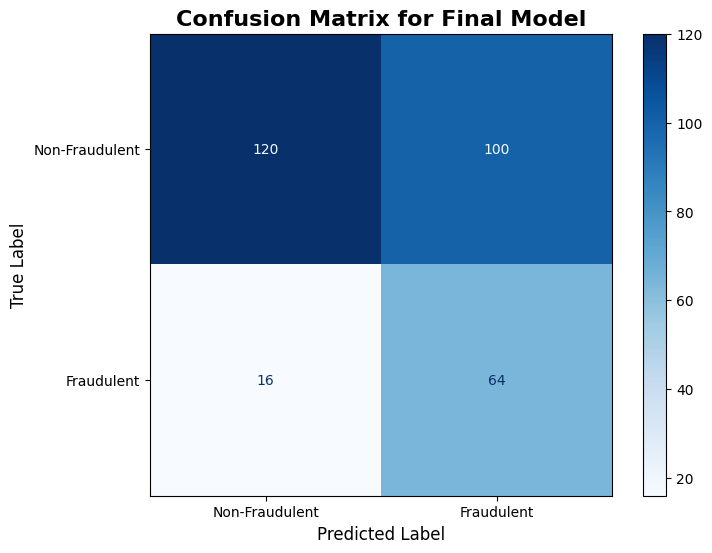

In [185]:
# Train the final model with the best parameters
best_params = study.best_params
rf_final = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    class_weight=best_params['class_weight'],
    random_state=42
)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42, k_neighbors=best_params['k_neighbors'])
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Fit the model on the resampled data
rf_final.fit(X_train_resampled, y_train_resampled)

# Evaluate on the test set
y_pred = (rf_final.predict_proba(X_test)[:, 1] >= 0.4).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Non-Fraudulent', 'Fraudulent']

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')

# Enhance the plot aesthetics
plt.title('Confusion Matrix for Final Model', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)  # Remove gridlines for a cleaner look
plt.show()

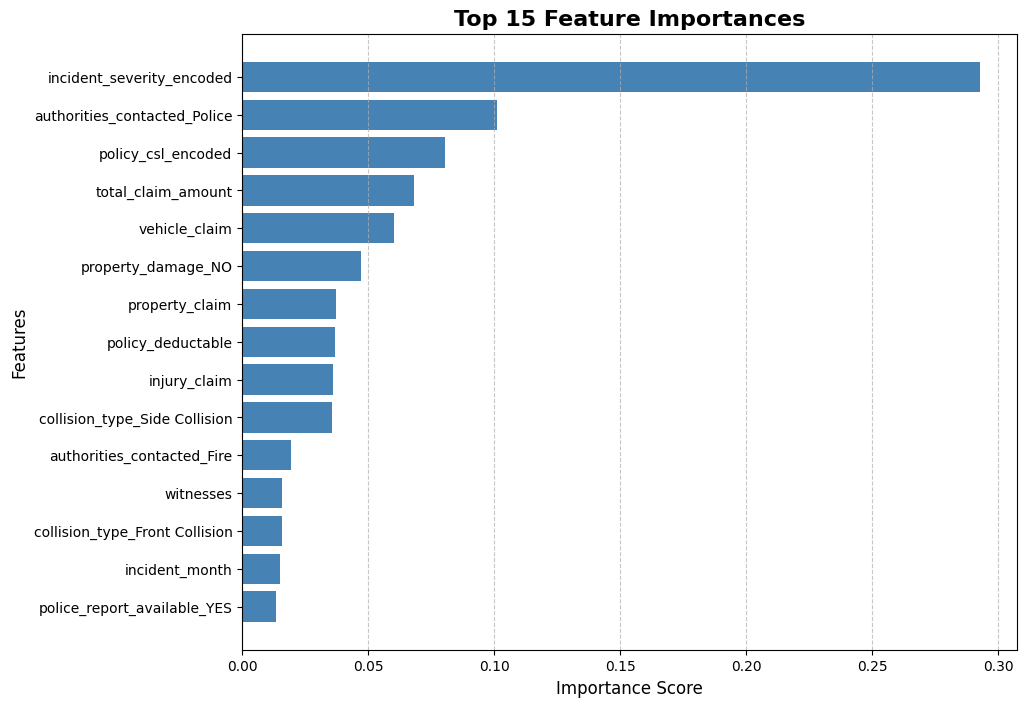

In [186]:
# Get feature importances from the final model
feature_importances = rf_final.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to sort and select the top 15 features
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).head(15)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.gca().invert_yaxis()  # To show the most important feature on top
plt.title('Top 15 Feature Importances', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add light gridlines for the x-axis
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Confusion Matrix of training set

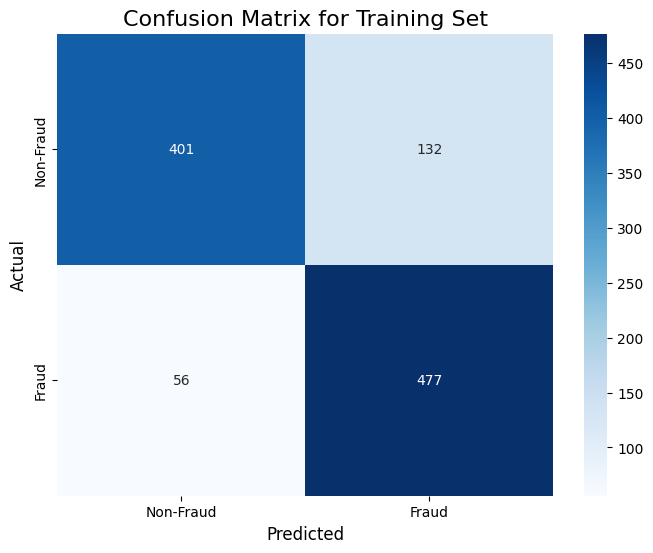

Classification Report (Training Set):

              precision    recall  f1-score   support

   Non-Fraud       0.88      0.75      0.81       533
       Fraud       0.78      0.89      0.84       533

    accuracy                           0.82      1066
   macro avg       0.83      0.82      0.82      1066
weighted avg       0.83      0.82      0.82      1066



In [187]:
# Generate predicted probabilities for the training set
probs_train = rf_final.predict_proba(X_train_resampled)[:, 1]  # Use resampled training data

# Apply custom threshold to classify predictions
threshold = 0.5
predictions_train = (probs_train >= threshold).astype(int)

# Generate the confusion matrix
cm_train = confusion_matrix(y_train_resampled, predictions_train)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix for Training Set", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()

# Print the classification report
print("Classification Report (Training Set):\n")
print(classification_report(y_train_resampled, predictions_train, target_names=["Non-Fraud", "Fraud"]))


# Building the XGBoost (Without SMOTE)

In [188]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Convert data into DMatrix format for training set
dtrain = xgb.DMatrix(X_train, label=y_train)

def objective(trial):
    # Define hyperparameter search space
    params = {
        'objective': 'binary:logistic',  # Binary classification objective
        'eval_metric': 'logloss',        # Logloss for early stopping
        'learning_rate': trial.suggest_float('eta', 0.01, 0.2),  # Learning rate (eta)
        'max_depth': trial.suggest_int('max_depth', 3, 10),       # Maximum depth of trees
        'subsample': trial.suggest_float('subsample', 0.5, 0.7),   # Subsampling ratio
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.8),  # Feature subsampling
        'reg_alpha': trial.suggest_float('reg_alpha', 0.5, 1),      # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 1),    # L2 regularization
        'gamma': trial.suggest_float('gamma', 0, 0.4),              # Minimum loss reduction required to make a further partition
        'seed': 42,                                           # Random seed for reproducibility
    }

    # 3-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    total_true_positives = 0

    # Perform cross-validation
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Convert the current fold into DMatrix format
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold)

        # Train the model
        num_boost_round = trial.suggest_int('n_estimators', 50, 150)  # Use this for num_boost_round

        model = xgb.train(
            params=params,
            dtrain=dtrain_fold,
            num_boost_round=num_boost_round,  # Use num_boost_round instead of n_estimators
            early_stopping_rounds=15,  # Stop early if validation loss doesn't improve
            evals=[(dval_fold, 'eval')],
            verbose_eval=False
        )

        # Predict on the validation fold
        y_pred_prob = model.predict(dval_fold)

        # Convert probabilities to binary predictions
        y_pred = (y_pred_prob >= 0.5).astype(int)

        # Calculate true positives
        true_positives = ((y_pred == 1) & (y_val_fold == 1)).sum()
        total_true_positives += true_positives

    # Return the total count of true positives across all folds
    return total_true_positives

# Optuna optimization
study = optuna.create_study(direction='maximize')  # Maximize the total true positives
study.optimize(objective, n_trials=50)

[I 2024-11-30 16:01:41,407] A new study created in memory with name: no-name-b107b838-aeef-4f9a-9f56-8b67ecc5dc6e
[I 2024-11-30 16:01:41,986] Trial 0 finished with value: 55.0 and parameters: {'eta': 0.03598040465321352, 'max_depth': 4, 'subsample': 0.5049797516245241, 'colsample_bytree': 0.7548962972279021, 'reg_alpha': 0.9630113015053268, 'reg_lambda': 0.5032031995252783, 'gamma': 0.12795065636380035, 'n_estimators': 127}. Best is trial 0 with value: 55.0.
[I 2024-11-30 16:01:42,234] Trial 1 finished with value: 58.0 and parameters: {'eta': 0.15889968071484373, 'max_depth': 3, 'subsample': 0.6727904453259768, 'colsample_bytree': 0.3650813201366645, 'reg_alpha': 0.8458171084462075, 'reg_lambda': 0.6410446139275119, 'gamma': 0.38859123436722015, 'n_estimators': 96}. Best is trial 1 with value: 58.0.
[I 2024-11-30 16:01:42,632] Trial 2 finished with value: 55.0 and parameters: {'eta': 0.09683839664330772, 'max_depth': 10, 'subsample': 0.6671938233202447, 'colsample_bytree': 0.7937648669

In [189]:
# Best hyperparameters
print("Best parameters:", study.best_params)
print("Best true positives:", study.best_value)

Best parameters: {'eta': 0.11013208420061009, 'max_depth': 6, 'subsample': 0.6458781665385778, 'colsample_bytree': 0.7986701124685562, 'reg_alpha': 0.705751918879435, 'reg_lambda': 0.6886918235860352, 'gamma': 0.15241375800587234, 'n_estimators': 124}
Best true positives: 66.0


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[16:02:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




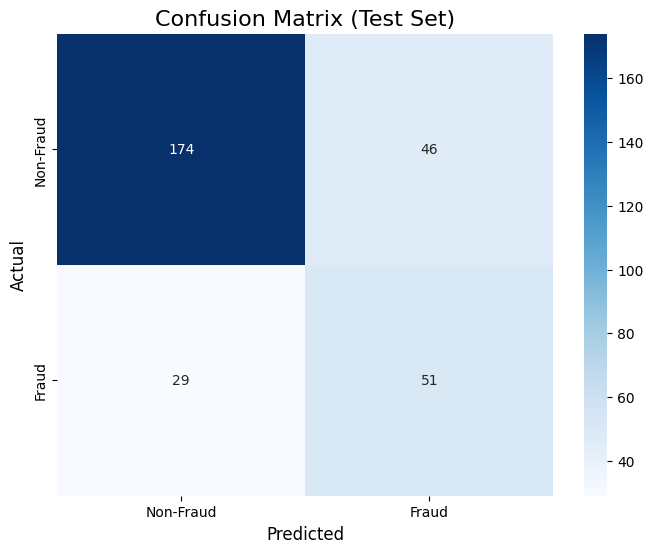

Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       220
           1       0.53      0.64      0.58        80

    accuracy                           0.75       300
   macro avg       0.69      0.71      0.70       300
weighted avg       0.77      0.75      0.76       300



In [190]:
# Train the final model using the best parameters on the full training set (X_train, y_train)
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=best_params['eta'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    gamma=best_params['gamma'],
    random_state=42,
    use_label_encoder=False  # Avoid warning related to label encoder
)

# Train the final model on the full training data
final_model.fit(X_train, y_train)

# Predict on the test set
probs_test = final_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
threshold = 0.16
y_pred = (probs_test >= threshold).astype(int)

# Confusion Matrix for Test Set
cm1 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix (Test Set)", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()

# Classification Report for Test Set
print("Classification Report (Test Set):\n")
print(classification_report(y_test, y_pred))

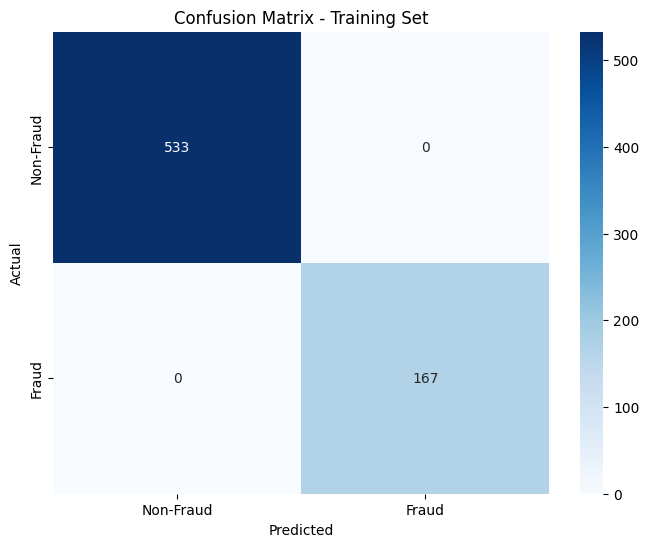

Classification Report - Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       533
           1       1.00      1.00      1.00       167

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700



In [191]:
y_pred_prob_train = final_model.predict(X_train)
final_threshold = 0.16
y_pred_train = (y_pred_prob_train >= final_threshold).astype(int)

# Confusion matrix for the training set
cm_train = confusion_matrix(y_train, y_pred_train)

# Plot confusion matrix using seaborn heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report for the training set
print("Classification Report - Training Set:")
print(classification_report(y_train, y_pred_train))

# Building the XGBoost (With SMOTE)

In [192]:
dtrain = xgb.DMatrix(X_train, label=y_train)

import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE  # Import SMOTE

# Convert data into DMatrix format for training set
dtrain = xgb.DMatrix(X_train, label=y_train)

def objective(trial):
    # Define hyperparameter search space
    params = {
        'objective': 'binary:logistic',  # Binary classification objective
        'eval_metric': 'logloss',        # Logloss for early stopping
        'learning_rate': trial.suggest_float('eta', 0.01, 0.2),  # Learning rate (eta)
        'max_depth': trial.suggest_int('max_depth', 3, 10),       # Maximum depth of trees
        'subsample': trial.suggest_float('subsample', 0.5, 0.7),   # Subsampling ratio
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.8),  # Feature subsampling
        'reg_alpha': trial.suggest_float('reg_alpha', 0.5, 1),      # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 1),    # L2 regularization
        'gamma': trial.suggest_float('gamma', 0, 0.4),              # Minimum loss reduction required to make a further partition
        'seed': 42,                                           # Random seed for reproducibility
    }

    # 3-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    total_true_positives = 0

    # Perform cross-validation
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Apply SMOTE to the training fold (only on the training data)
        smote = SMOTE(random_state=42)  # Initialize SMOTE
        X_train_fold_smote, y_train_fold_smote = smote.fit_resample(X_train_fold, y_train_fold)

        # Convert the current fold into DMatrix format
        dtrain_fold = xgb.DMatrix(X_train_fold_smote, label=y_train_fold_smote)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold)  # No SMOTE on validation fold

        # Train the model
        num_boost_round = trial.suggest_int('n_estimators', 50, 150)  # Use this for num_boost_round

        model = xgb.train(
            params=params,
            dtrain=dtrain_fold,
            num_boost_round=num_boost_round,  # Use num_boost_round instead of n_estimators
            early_stopping_rounds=15,  # Stop early if validation loss doesn't improve
            evals=[(dval_fold, 'eval')],
            verbose_eval=False
        )

        # Predict on the validation fold
        y_pred_prob = model.predict(dval_fold)

        # Convert probabilities to binary predictions
        y_pred = (y_pred_prob >= 0.5).astype(int)

        # Calculate true positives
        true_positives = ((y_pred == 1) & (y_val_fold == 1)).sum()
        total_true_positives += true_positives

    # Return the total count of true positives across all folds
    return total_true_positives

# Optuna optimization
study = optuna.create_study(direction='maximize')  # Maximize the total true positives
study.optimize(objective, n_trials=50)

[I 2024-11-30 16:02:08,881] A new study created in memory with name: no-name-e22b27ac-0466-4612-a042-61fd3db7eb53
[I 2024-11-30 16:02:09,289] Trial 0 finished with value: 83.0 and parameters: {'eta': 0.1998654657388805, 'max_depth': 6, 'subsample': 0.6848571717944795, 'colsample_bytree': 0.6407672176167855, 'reg_alpha': 0.9018819826072607, 'reg_lambda': 0.8465672422556341, 'gamma': 0.2796062547755487, 'n_estimators': 139}. Best is trial 0 with value: 83.0.
[I 2024-11-30 16:02:09,778] Trial 1 finished with value: 76.0 and parameters: {'eta': 0.1919719458669943, 'max_depth': 10, 'subsample': 0.5617400012357932, 'colsample_bytree': 0.722470526766168, 'reg_alpha': 0.8942193062573116, 'reg_lambda': 0.5938995075927025, 'gamma': 0.10100019988490319, 'n_estimators': 57}. Best is trial 0 with value: 83.0.
[I 2024-11-30 16:02:11,135] Trial 2 finished with value: 82.0 and parameters: {'eta': 0.14042257906257255, 'max_depth': 8, 'subsample': 0.631564464302429, 'colsample_bytree': 0.774967905382870

In [193]:
# Best hyperparameters
print("Best parameters:", study.best_params)
print("Best true positives:", study.best_value)

Best parameters: {'eta': 0.010951378710250998, 'max_depth': 3, 'subsample': 0.6163681235692388, 'colsample_bytree': 0.5495025356690039, 'reg_alpha': 0.735339334983414, 'reg_lambda': 0.6516221831771795, 'gamma': 0.3964381900827705, 'n_estimators': 92}
Best true positives: 114.0


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[16:02:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




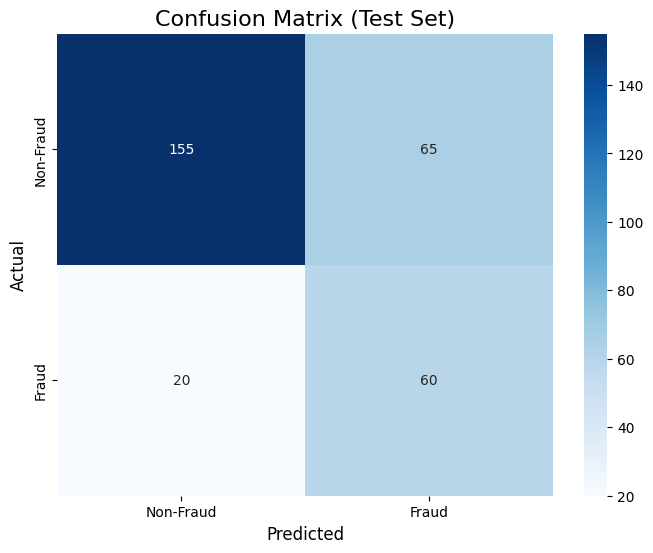

Classification Report (Test Set):

              precision    recall  f1-score   support

           0       0.89      0.70      0.78       220
           1       0.48      0.75      0.59        80

    accuracy                           0.72       300
   macro avg       0.68      0.73      0.69       300
weighted avg       0.78      0.72      0.73       300



In [194]:
# Train the final model using the best parameters on the full training set (X_train, y_train)
best_params = study.best_params
final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=best_params['eta'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    gamma=best_params['gamma'],
    random_state=42,
    use_label_encoder=False  # Avoid warning related to label encoder
)

# Apply SMOTE to the full training data before fitting the final model
smote = SMOTE(random_state=42)  # Initialize SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)  # Apply SMOTE to training set only

# Train the final model on the resampled data
final_model.fit(X_train_smote, y_train_smote)

# Predict on the test set
probs_test = final_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
threshold = 0.41
y_pred = (probs_test >= threshold).astype(int)

# Confusion Matrix for Test Set
cm1 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix (Test Set)", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()

# Classification Report for Test Set
print("Classification Report (Test Set):\n")
print(classification_report(y_test, y_pred))

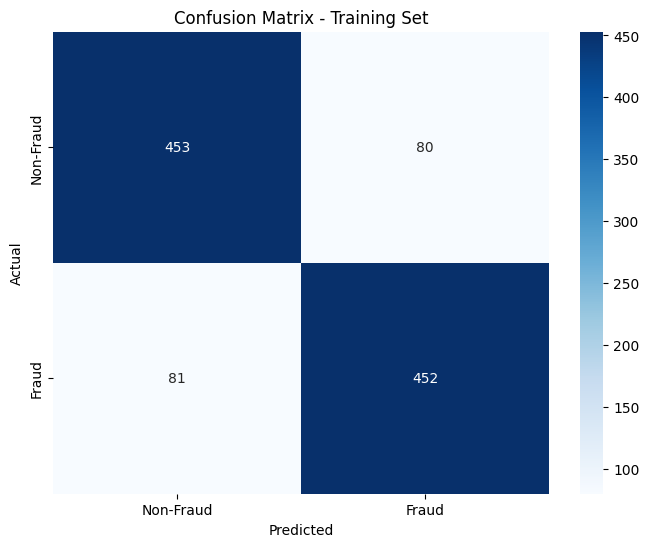

Classification Report - Training Set:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       533
           1       0.85      0.85      0.85       533

    accuracy                           0.85      1066
   macro avg       0.85      0.85      0.85      1066
weighted avg       0.85      0.85      0.85      1066



In [195]:
# Predict on the training set
y_pred_prob_train = final_model.predict(X_train_smote)
final_threshold = 0.41
y_pred_train = (y_pred_prob_train >= final_threshold).astype(int)

# Confusion matrix for the training set
cm_train = confusion_matrix(y_train_smote, y_pred_train)

# Plot confusion matrix using seaborn heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report for the training set
print("Classification Report - Training Set:")
print(classification_report(y_train_smote, y_pred_train))